In [1]:
import numpy as np
import torch
import pandas as pd
from torch import nn
from PIL import Image
import os
from torchsummary import summary
import torch.nn.functional as F
from torchvision import transforms, datasets


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
data_dir = '/content/gdrive/MyDrive/datasets/palmdata'
os.chdir(data_dir)

Mounted at /content/gdrive


In [3]:
!ls

test  train


In [4]:
class PalmDataSet(torch.utils.data.Dataset):        # Подготовил класс датасета
    def __init__(self, path_dataset, transform=None):
        self.path_dataset = path_dataset
        self._dataset = pd.read_csv(self.path_dataset + 'label.csv', sep=';')
        self.transform = transform

    def __len__(self):
        return self._dataset.shape[0]

    def __getitem__(self, idx):
        img = Image.open(self.path_dataset + self._dataset.FileName.iloc[idx])    
        lbl_Side = 1 if self._dataset.Side.iloc[idx]=='Right' else 0
        lbl_Angle = self._dataset.Angle.iloc[idx]        
        if self.transform is not None:
            img = self.transform(img)
        return img, (lbl_Angle, lbl_Side) # (изображение, (угол, 0/1))

In [5]:
trans_actions = transforms.Compose([transforms.Resize(size=(224, 224)), 
                                    transforms.ToTensor()])

In [6]:
test_dataset = PalmDataSet('test/', transform=trans_actions)
train_dataset = PalmDataSet('train/', transform=trans_actions)

In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=32,
                          shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                          batch_size=32,
                          shuffle=False)

Основная задача делится на две:


1.   бинарная классификация - определить левая/правая ладошка
2.   регрессия - определить угол поворота ладошки


Я хотел попробовать в рамках одной сети сделать один сверточный блок, а после него сделать два независимых полносвязных блока: на классификацию и на регрессию.

Таким образом хотел попробовать сделать два выхода у сети.


In [12]:
class PalmNet(nn.Module):
    def __init__(self):
        super(PalmNet, self).__init__()
        self.conv = nn.Sequential( # Сверточный блок: Нормализация -> Свертка -> Ф-я активации -> Макс. Пуллинг 
            nn.BatchNorm2d(1), 
            nn.Conv2d(1, 64, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size =2, stride=2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 256, 3),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size =2, stride=2),            
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 3),
            nn.LeakyReLU(),
            nn.BatchNorm2d(512)             
        )

        self.fc_side = nn.Sequential( # полносвязный блок (классификация): 3 слоя, имеется регуляризация dropout
            nn.Linear(512, 1000),
            nn.ReLU(),
            nn.Dropout(0.25),  
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()           
        )
        self.fc_angle = nn.Sequential( #Полносвязный блок (регрессия)
            nn.Linear(512, 1000),
            nn.ReLU(),
            nn.Dropout(0.25),  
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Linear(100, 1),        
        )    

        
    def forward(self, x): 
        x = self.conv(x)                              # Изображение проходит через сверточный блок
        x = F.max_pool2d(x, kernel_size=x.size()[2:]) # 
        x = x.view(x.size(0), -1)
        out_side = self.fc_side(x)                    # После свертки отдельно проводим через слои бинарного классификатора (лево/право)
        out_angle = self.fc_angle(x)                  # После свертки отдельно проводим через слои регрессии (для определения угла)
        out = torch.cat((out_side, out_angle), 1)     
        return out
       
net = PalmNet()

In [13]:
summary(net, input_size=(1, 225, 225))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [-1, 1, 225, 225]               2
            Conv2d-2         [-1, 64, 223, 223]             640
         LeakyReLU-3         [-1, 64, 223, 223]               0
         MaxPool2d-4         [-1, 64, 111, 111]               0
       BatchNorm2d-5         [-1, 64, 111, 111]             128
            Conv2d-6        [-1, 256, 109, 109]         147,712
         LeakyReLU-7        [-1, 256, 109, 109]               0
         MaxPool2d-8          [-1, 256, 54, 54]               0
       BatchNorm2d-9          [-1, 256, 54, 54]             512
           Conv2d-10          [-1, 512, 52, 52]       1,180,160
        LeakyReLU-11          [-1, 512, 52, 52]               0
      BatchNorm2d-12          [-1, 512, 52, 52]           1,024
           Linear-13                 [-1, 1000]         513,000
             ReLU-14                 [-

In [14]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001) # оптимизатор обучения
'''Так как две задачи и два блока - нужно выбрать две функции активации '''
criterion_1 = nn.BCELoss()    #Бинарная кросс энтропия - ф-ая потерь для бинарной классификации                              
criterion_2 = nn.MSELoss()    #Среднеквадратичная ошибка (Mean squared error) - для регрессии

In [17]:
num_epochs = 10   # кол-во эпох обучения
threshold = 0.5   # граница для распределения лево/право 
net.train()

for epoch in range(num_epochs): 
    running_loss_1, running_loss_2 = 0.0, 0.0    
    
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels_side, labels_angel = data[0], data[1][1], data[1][0] #загружаем текущие данные

        optimizer.zero_grad()                                               # обнуляем градиенты
        outputs = net(inputs)                                               # загружаем в есть изображение и получаем выходы из сети (их 2)
        loss_1 = criterion_1(outputs[:,0], labels_side.to(torch.float32))   # находим значение потерь по BCE
        loss_2 = criterion_2(outputs[:,1], labels_angel.to(torch.float32))  # находим значение потерь по MSE
        loss = torch.cat([loss_1.reshape(1), loss_2.reshape(1)])            # соединяем в один массив
        loss.backward(torch.ones_like(loss))                                # находим градиенты 
        optimizer.step()                                                    # делаем шаг оптимизатора - изменяем веса

        # выводим статистику о процессе обучения
        running_loss_1 += loss_1.item()
        running_loss_2 += loss_2.item()        
        running_items += len(inputs)
        running_right += (labels_side == (outputs[:,0]>threshold).to(torch.int64)).sum()        
        
        if i % 63 == 0:                                                    # печатаем первую итерацию
            net.eval()                                                     # переводим сеть в режим предсказания
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss_1: {running_loss_1 / running_items:.3f}. '\
                  f'Loss_2: {running_loss_2 / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0    

            
            test_running_right, test_running_items = 0.0, 0.0
            for i, data in enumerate(test_loader):                        # пробегаем по тестовому датасету и смотрим результаты
                inputs, labels_side, labels_angel = data[0], data[1][1], data[1][0]
                test_outputs = net(inputs)
                
                
                test_running_items += len(inputs)
                test_running_right += (labels_side == (test_outputs[:,0]>threshold).to(torch.int64)).sum()   
                test_mse = criterion_2(test_outputs[:,1], labels_angel.to(torch.float32))
            print(f'Test acc: {test_running_right / test_running_items:.3f}. '  \
                  f'MSE_Loss: {test_mse / test_running_items:.3f}.')
        net.train()                                                       # переводим в режим обучения
        
print('Training is finished!')        
        
        
        
        

Epoch [1/10]. Step [1/63]. Loss_1: 0.021. Loss_2: 1069.466. Acc: 0.625. Test acc: 0.237. MSE_Loss: 39.924.
Epoch [2/10]. Step [1/63]. Loss_1: 0.013. Loss_2: 13.808. Acc: 0.812. Test acc: 0.946. MSE_Loss: 3.210.
Epoch [3/10]. Step [1/63]. Loss_1: 0.006. Loss_2: 4.286. Acc: 0.938. Test acc: 0.952. MSE_Loss: 0.069.
Epoch [4/10]. Step [1/63]. Loss_1: 0.004. Loss_2: 4.867. Acc: 0.938. Test acc: 0.942. MSE_Loss: 0.012.
Epoch [5/10]. Step [1/63]. Loss_1: 0.003. Loss_2: 4.283. Acc: 1.000. Test acc: 0.938. MSE_Loss: 0.008.
Epoch [6/10]. Step [1/63]. Loss_1: 0.002. Loss_2: 1.875. Acc: 0.969. Test acc: 0.902. MSE_Loss: 0.005.
Epoch [7/10]. Step [1/63]. Loss_1: 0.001. Loss_2: 1.095. Acc: 1.000. Test acc: 0.934. MSE_Loss: 0.015.
Epoch [8/10]. Step [1/63]. Loss_1: 0.004. Loss_2: 2.144. Acc: 0.969. Test acc: 0.942. MSE_Loss: 0.003.
Epoch [9/10]. Step [1/63]. Loss_1: 0.002. Loss_2: 1.536. Acc: 0.969. Test acc: 0.945. MSE_Loss: 0.002.
Epoch [10/10]. Step [1/63]. Loss_1: 0.007. Loss_2: 1.561. Acc: 0.938

In [18]:
net.eval()
new_test_loader =test_loader = torch.utils.data.DataLoader(test_dataset,
                          batch_size=32,
                          shuffle=False) 

In [25]:
res = []
for i, data in enumerate(new_test_loader):
  inputs, labels_side, labels_angle = data[0], data[1][1], data[1][0]
  res = net(inputs)
  break

In [26]:
import matplotlib.pyplot as plt

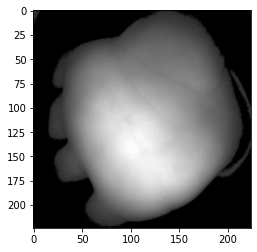

Target Side: 1; Result Side: 1
Target Angle: 201.6; Result Angle: 198.892822265625


In [42]:
i = 1
img = inputs[i].squeeze()
plt.imshow(img, cmap="gray")
plt.show()
print(f'Target Side: {labels_side[i] }; Result Side: {round(float(res[i][0]))}\n'\
      f'Target Angle: {labels_angle[i]}; Result Angle: {res[i][1]}')

In [43]:
torch.save(net, 'palm_net.pth')